# 🛠️ Setup

In [10]:
import os

# Data

## 🔢 Data ingestion

In [11]:
import pandas as pd

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:

# Data ingestion
DATASET_LOC = "/content/drive/MyDrive/Made-With-ML/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


## ✂️ Data splitting

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# Value counts
df.tag.value_counts()

,count
tag,
natural-language-processing,310
computer-vision,285
other,106
mlops,63


In [16]:
# Split dataset
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

In [17]:
# Train value counts
train_df.tag.value_counts()

,count
tag,
natural-language-processing,248
computer-vision,228
other,85
mlops,50


In [18]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1-test_size) / test_size)

,count
tag,
natural-language-processing,248
computer-vision,228
other,84
mlops,52


## 🔍 Exploratory Data Analysis (EDA)

Exploratory data analysis to understand the signals and nuances of our dataset. It's a cyclical process that can be done at various points of our development process (before/after labeling, preprocessing, etc.) depending on how well the problem is defined.

In [19]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS

In [20]:
# Most common tags
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

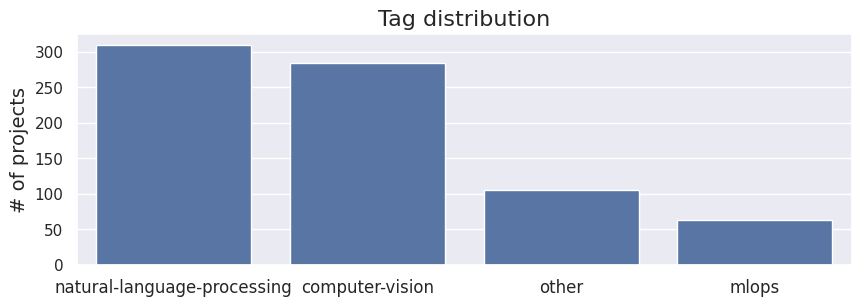

In [21]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=12)
plt.title("Tag distribution", fontsize=16)
plt.ylabel("# of projects", fontsize=14)
plt.show()

> We'll address the [data imbalance](https://madewithml.com/courses/mlops/baselines#data-imbalance) after splitting into our train split and prior to training our model.

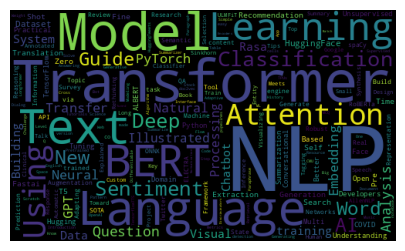

In [22]:
# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

Looks like the `title` text feature has some good signal for the respective classes and matches our intuition. We can repeat this for the `description` text feature as well. This information will become useful when we decide how to use our features for modeling.

## ✨ Data Preprocessing

Preprocessing the data via feature engineering, filtering and cleaning. Certain preprocessing steps are global (don't depend on our dataset, ex. lower casing text, removing stop words, etc.) and others are local (constructs are learned only from the training split, ex. vocabulary, standardization, etc.). For the local, dataset-dependent preprocessing steps, we want to ensure that we [split](https://madewithml.com/courses/mlops/splitting) the data first before preprocessing to avoid data leaks.

In [23]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

### Feature engineering

We can combine existing input features to create new meaningful signal (helping the model learn).

In [24]:
# Feature engineering
df["text"] = df.title + " " + df.description

### Clean text

In [25]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [27]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


### Clean DataFrame

In [28]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


### Label encoding

We need to encode our data into numerical values so that our models can process them. We'll start by encoding our text labels into unique indices.

In [29]:
# Label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [30]:
# Encode labels
df["tag"] = df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [31]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [32]:
index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

### Tokenizer

Next we'll encode our text as well. Instead of using a random dictionary, we'll use a [tokenizer](https://huggingface.co/allenai/scibert_scivocab_uncased/blob/main/vocab.txt) that was used for a pretrained LLM ([scibert](https://huggingface.co/allenai/scibert_scivocab_uncased)) to tokenize our text. We'll be fine-tuning this exact model later when we train our model.

In [33]:
import numpy as np
from transformers import BertTokenizer

In [34]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [35]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [36]:
# Tokenization
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([2])}

In [37]:
# def preprocess(df, class_to_index):
#     """Preprocess the data."""
#     df["text"] = df.title + " " + df.description  # feature engineering
#     df["text"] = df.text.apply(clean_text)  # clean text
#     df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
#     df = df[["text", "tag"]]  # rearrange columns
#     df["tag"] = df["tag"].map(class_to_index)  # label encoding
#     outputs = tokenize(df)
#     return outputs

In [29]:
# # Apply
# preprocess(df=train_df, class_to_index=class_to_index)

# Training

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Clean the text column
df['cleaned_text'] = df['text'].apply(clean_text)

# Split the dataset into training and testing sets (features: cleaned_text, labels: tag)
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['tag'], test_size=0.2, random_state=42)

# Convert text data into numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize a Logistic Regression model
model = LogisticRegression()

# Train the model
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8235
              precision    recall  f1-score   support

           0       1.00      0.25      0.40        12
           1       0.76      0.95      0.84        60
           2       0.85      0.86      0.85        58
           3       1.00      0.70      0.82        23

    accuracy                           0.82       153
   macro avg       0.90      0.69      0.73       153
weighted avg       0.85      0.82      0.81       153



## 🤖 Model

In [39]:
!pip install transformers torch


In [40]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from transformers import AdamW
from sklearn.model_selection import train_test_split


In [41]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        # Tokenize the input text
        inputs = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [42]:
# Load SciBERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
model = BertModel.from_pretrained("allenai/scibert_scivocab_uncased")


pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

## 📦 Batching

In [44]:
# Define train_loop_config with the desired batch_size
train_loop_config = {'batch_size': 32}  # You can change 32 to your desired batch size

In [45]:
# Clean the text column if not already done
df['cleaned_text'] = df['text'].apply(clean_text)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['tag'], test_size=0.2, random_state=42)

# Create dataset objects
train_dataset = TextDataset(X_train.tolist(), y_train.tolist(), tokenizer, max_length=512)
test_dataset = TextDataset(X_test.tolist(), y_test.tolist(), tokenizer, max_length=512)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=train_loop_config['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=train_loop_config['batch_size'], shuffle=False)


## 🚂 Training

In [47]:
# Define train_loop_config with the desired batch_size and learning rate
train_loop_config = {
    'batch_size': 32,  # You can change 32 to your desired batch size
    'lr': 2e-5,       # Add a learning rate (lr) to the config
    'num_epochs': 10 # Add num of epochs to the config
}

In [48]:
# Training parameters
num_classes = len(df['tag'].unique())
model = model.to('cuda')  # Move model to GPU if available

optimizer = AdamW(model.parameters(), lr=train_loop_config['lr'])

# Train loop
for epoch in range(train_loop_config['num_epochs']):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs[0][:, 0, :]  # Extract the logits

        # Calculate loss
        loss = torch.nn.functional.cross_entropy(logits, labels)
        total_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{train_loop_config["num_epochs"]}, Loss: {avg_loss:.4f}')


Epoch 1/3, Loss: 4.0969
Epoch 2/3, Loss: 1.4572
Epoch 3/3, Loss: 1.0070


### Evaluation

In [49]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

def predict(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs[0][:, 0, :]  # Extract the logits

            # Get predicted labels
            predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(predicted_labels)

    return np.array(predictions)

# Make predictions on the test set
y_pred = predict(model, test_loader)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7255
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.90      0.75      0.82        60
           2       0.62      1.00      0.76        58
           3       0.89      0.35      0.50        23

    accuracy                           0.73       153
   macro avg       0.60      0.52      0.52       153
weighted avg       0.72      0.73      0.69       153



In [50]:
# Test (holdout) dataset
HOLDOUT_LOC = "/content/drive/MyDrive/Made-With-ML/holdout.csv"

In [51]:
# Step 1: Load the Holdout Dataset
holdout_data = pd.read_csv(HOLDOUT_LOC)

In [52]:
# Display the first few rows and column names
print(holdout_data.head())
print(holdout_data.columns)

   id           created_on                         title  \
0  19  2020-03-03 13:54:31           Diffusion to Vector   
1  26  2020-03-07 23:11:58  Graph Wavelet Neural Network   
2  44  2020-03-08 00:32:58  Capsule Graph Neural Network   
3  80  2020-03-20 05:59:32  NeRF: Neural Radiance Fields   
4  84  2020-03-20 15:18:43            Mention Classifier   

                                         description  \
0  Reference implementation of Diffusion2Vec (Com...   
1  A PyTorch implementation of "Graph Wavelet Neu...   
2  A PyTorch implementation of "Capsule Graph Neu...   
3  Representing scenes as neural radiance fields ...   
4  Category prediction model\nThis repo contains ...   

                           tag  
0                        other  
1                        other  
2                        other  
3              computer-vision  
4  natural-language-processing  
Index(['id', 'created_on', 'title', 'description', 'tag'], dtype='object')


In [53]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder

# Step 1: Clean the text using your cleaning function
holdout_data['cleaned_text'] = holdout_data['description'].apply(clean_text)

# Step 2: Encode the labels
label_encoder = LabelEncoder()
holdout_data['encoded_labels'] = label_encoder.fit_transform(holdout_data['tag'])

# Step 3: Create a Dataset and DataLoader for the Holdout Set
holdout_dataset = TextDataset(
    holdout_data['cleaned_text'].tolist(),
    holdout_data['encoded_labels'].tolist(),  # Use encoded labels
    tokenizer,
    max_length=512
)
holdout_loader = DataLoader(holdout_dataset, batch_size=train_loop_config['batch_size'], shuffle=False)

# Step 4: Make Predictions on the Holdout Set
y_holdout_pred = predict(model, holdout_loader)

# Step 5: Decode the predictions back to original labels
y_holdout_pred_labels = label_encoder.inverse_transform(y_holdout_pred)

# Step 6: Evaluate the Model on the Holdout Set
y_holdout_true = holdout_data['tag'].values
accuracy_holdout = accuracy_score(y_holdout_true, y_holdout_pred_labels)
print(f"Holdout Accuracy: {accuracy_holdout:.4f}")
print(classification_report(y_holdout_true, y_holdout_pred_labels))

Holdout Accuracy: 0.1937
                             precision    recall  f1-score   support

            computer-vision       0.00      0.00      0.00        71
                      mlops       0.12      0.56      0.19        16
natural-language-processing       0.16      0.21      0.18        78
                      other       0.92      0.46      0.62        26

                   accuracy                           0.19       191
                  macro avg       0.30      0.31      0.25       191
               weighted avg       0.20      0.19      0.17       191



In [ ]:
# # Evaluate by Goku
# metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
# {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

{'precision': 0.9138952286238713,
 'recall': 0.9109947643979057,
 'f1': 0.9114851103432928}

In [54]:
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support # Added precision_recall_fscore_support

# Compute precision, recall, and f1 score (weighted average)
metrics = precision_recall_fscore_support(y_holdout_true, y_holdout_pred_labels, average="weighted")
precision = metrics[0]
recall = metrics[1]
f1 = metrics[2]
print({"precision": precision, "recall": recall, "f1": f1})

{'precision': 0.20078602026246004, 'recall': 0.193717277486911, 'f1': 0.17339919426000389}


### Inference

In [55]:
import pandas as pd

In [58]:
def predict_with_probabilities(model, text, tokenizer, class_to_index, index_to_class, max_length=512):
    """Predicts the tag for the given text and returns the prediction and probabilities for each tag."""

    model.eval()
    inputs = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    input_ids = inputs['input_ids'].to('cuda')
    attention_mask = inputs['attention_mask'].to('cuda')

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs[0][:, 0, :]

        # Softmax to get probabilities
        probabilities = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()[0]

        # Get predicted label index
        predicted_label_index = torch.argmax(logits, dim=1).cpu().numpy()[0]

        # Decode to original label
        predicted_label = index_to_class[predicted_label_index]

        # Create a dictionary of tag probabilities
        tag_probabilities = {tag: prob for tag, prob in zip(tags, probabilities)}

    return {
        'prediction': predicted_label,
        'probabilities': tag_probabilities
    }


# Example usage:
example_texts = ["This is a project about computer vision.", "This is a project about MLOps.", "This is a project about natural language processing."]
for text in example_texts:
    prediction_result = predict_with_probabilities(
        model, text, tokenizer, class_to_index, index_to_class
    )
    print(prediction_result)


{'prediction': 'computer-vision', 'probabilities': {'mlops': 0.0066262097, 'natural-language-processing': 0.039533243, 'computer-vision': 0.56596506, 'other': 0.027704503}}
{'prediction': 'natural-language-processing', 'probabilities': {'mlops': 0.010227406, 'natural-language-processing': 0.22630809, 'computer-vision': 0.19183728, 'other': 0.013734404}}
{'prediction': 'natural-language-processing', 'probabilities': {'mlops': 0.004091467, 'natural-language-processing': 0.72878206, 'computer-vision': 0.026542341, 'other': 0.0039859973}}


In [ ]:
# # Inference by Goku
# title = "Transfer learning with transformers"
# description = "Using transformers for transfer learning on text classification tasks."
# sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
# predict_proba(ds=sample_ds, predictor=predictor)

2023-09-17 22:42:00,133	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2023-09-17 22:42:00,134	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:42:00,134	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'prediction': 'natural-language-processing',
  'probabilities': {'computer-vision': 0.00035399722,
   'mlops': 0.00030543839,
   'natural-language-processing': 0.9990171,
   'other': 0.0003234732}}]

# ⚖️ Evaluation

So far we've been evaluating our models by determing the overall precision, recall and f1 scores. But since performance is one of the key decision making factors when comparing different models, we should have even more nuanced evaluation strategies.

- Coarse-grained metrics
- Fine-grained metrics
- Confusion matrix
- Confidence learning
- Slice metrics

### Coarse-grained metrics

In [60]:
from sklearn.metrics import precision_recall_fscore_support

# Assuming y_holdout_true and y_holdout_pred_labels are defined from previous steps

# Compute precision, recall, and f1 score (weighted average)
metrics = precision_recall_fscore_support(y_holdout_true, y_holdout_pred_labels, average="weighted")
precision = metrics[0]
recall = metrics[1]
f1 = metrics[2]

print({"precision": precision, "recall": recall, "f1": f1})

# Count num_samples
num_samples = len(y_holdout_true)
print(f"Number of samples in the holdout set: {num_samples}")


{'precision': 0.20078602026246004, 'recall': 0.193717277486911, 'f1': 0.17339919426000389}
Number of samples in the holdout set: 191


### Fine-grained metrics

In [61]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate fine-grained metrics for each tag
precision, recall, f1_score, support = precision_recall_fscore_support(y_holdout_true, y_holdout_pred_labels, average=None)

# Print results
for i, tag in enumerate(label_encoder.classes_):
    print(f"Tag: {tag}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1_score[i]:.4f}")
    print(f"  Support: {support[i]}")


Tag: computer-vision
  Precision: 0.0000
  Recall: 0.0000
  F1-score: 0.0000
  Support: 71
Tag: mlops
  Precision: 0.1169
  Recall: 0.5625
  F1-score: 0.1935
  Support: 16
Tag: natural-language-processing
  Precision: 0.1600
  Recall: 0.2051
  F1-score: 0.1798
  Support: 78
Tag: other
  Precision: 0.9231
  Recall: 0.4615
  F1-score: 0.6154
  Support: 26


### Confusion matrix

- **True positives (TP)**: learn about where our model performs well.
- **False positives (FP)**: potentially identify samples which may need to be relabeled.
- False negatives (FN): identify the model's less performant areas to oversample later.

> It's a good to have our FP/FN samples feed back into our annotation pipelines in the event we want to fix their labels and have those changes be reflected everywhere.

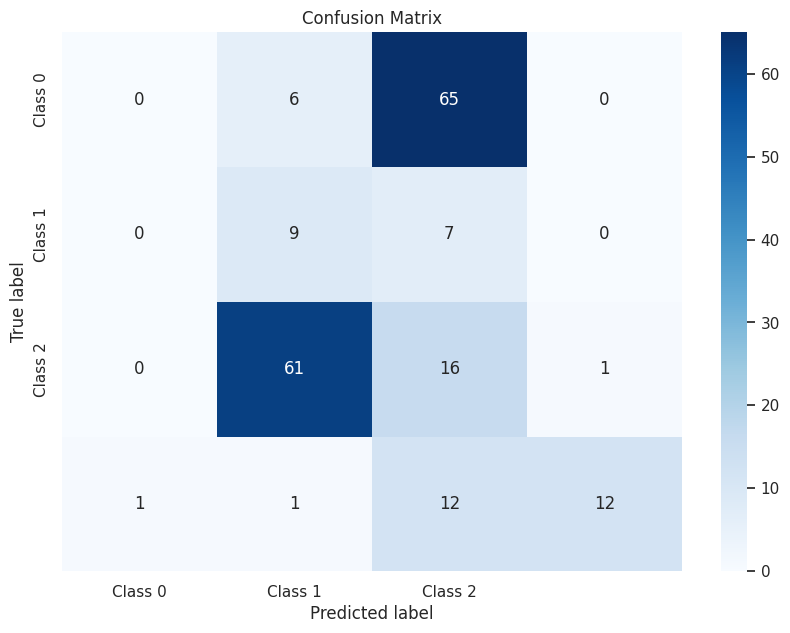

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_holdout_true, y_holdout_pred_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],  # Update with your class names
            yticklabels=['Class 0', 'Class 1', 'Class 2'])  # Update with your class names
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [63]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
# conf_matrix = confusion_matrix(y_holdout_true, y_holdout_pred_labels)

# Identify true positives, false positives, and false negatives
tp = []
fp = []
fn = []
for i in range(len(y_holdout_true)):
    true_label = y_holdout_true[i]
    predicted_label = y_holdout_pred_labels[i]
    if true_label == predicted_label:
        tp.append(i)
    elif true_label != predicted_label and predicted_label != 'other':
        fp.append(i)
    elif true_label != predicted_label and true_label != 'other':
        fn.append(i)

# Samples
num_samples = 3
cm = [(tp, "True positives"), (fp, "False positives"), (fn, "False negatives")]
for item in cm:
    if len(item[0]):
        print (f"\n=== {item[1]} ===")
        for index in item[0][:num_samples]:
            print (f"{holdout_data.iloc[index].description}")
            print (f"    true: {holdout_data.tag[index]}")
            print (f"    pred: {y_holdout_pred_labels[index]}\n")




=== True positives ===
Walking through a port of the RoBERTa pre-trained model to JAX + Haiku, then fine-tuning the model to solve a downstream task.
    true: natural-language-processing
    pred: natural-language-processing

🐳 Implementation of various Distributional Reinforcement Learning Algorithms using TensorFlow2.
    true: other
    pred: other

A close look at how RNNs are able to perform so well.
    true: natural-language-processing
    pred: natural-language-processing


=== False positives ===
Reference implementation of Diffusion2Vec (Complenet 2018) built on Gensim and NetworkX. 
    true: other
    pred: natural-language-processing

A PyTorch implementation of "Graph Wavelet Neural Network" (ICLR 2019) 
    true: other
    pred: natural-language-processing

A PyTorch implementation of "Capsule Graph Neural Network" (ICLR 2019).
    true: other
    pred: natural-language-processing


=== False negatives ===
Characterizes a large and thoughtful selection of recent effici

### Confidence learning

While the confusion-matrix sample analysis was a coarse-grained process, we can also use fine-grained confidence based approaches to identify potentially mislabeled samples. Here we’re going to focus on the specific labeling quality as opposed to the final model predictions.

Simple confidence based techniques include identifying samples whose:

**Categorical**
- prediction is incorrect (also indicate TN, FP, FN)
- confidence score for the correct class is below a threshold
- confidence score for an incorrect class is above a threshold
- standard deviation of confidence scores over top N samples is low
- different predictions from same model using different parameters

**Continuous**
- difference between predicted and ground-truth values is above some %



> The operations in this section can be applied to entire labeled dataset to discover labeling errors via confidence learning.

In [64]:
def predict_with_probabilities(model, text, tokenizer, class_to_index, index_to_class, max_length=512):
    """Predicts the tag for the given text and returns the prediction and probabilities for each tag."""

    model.eval()
    inputs = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    input_ids = inputs['input_ids'].to('cuda')
    attention_mask = inputs['attention_mask'].to('cuda')

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs[0][:, 0, :]

        # Softmax to get probabilities
        probabilities = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()[0]

        # Get predicted label index
        predicted_label_index = torch.argmax(logits, dim=1).cpu().numpy()[0]

        # Decode to original label
        predicted_label = index_to_class[predicted_label_index]

        # Create a dictionary of tag probabilities
        tag_probabilities = {tag: prob for tag, prob in zip(tags, probabilities)}

    return {
        'prediction': predicted_label,
        'probabilities': tag_probabilities
    }


# Get probabilities for each prediction on the holdout set
holdout_probabilities = []
for text in holdout_data['cleaned_text']:
    prediction_result = predict_with_probabilities(
        model, text, tokenizer, class_to_index, index_to_class
    )
    holdout_probabilities.append(prediction_result['probabilities'])

# Convert probabilities to a DataFrame
probabilities_df = pd.DataFrame(holdout_probabilities)

# Identify samples with low confidence for the correct label
confidence_threshold = 0.7  # Adjust this threshold as needed
low_confidence_samples = []
for i in range(len(y_holdout_true)):
    true_label = y_holdout_true[i]
    predicted_label = y_holdout_pred_labels[i]
    if true_label == predicted_label:
        if probabilities_df.loc[i, true_label] < confidence_threshold:
            low_confidence_samples.append(i)

# Print some samples with low confidence for the correct label
num_samples = 3
print("\n=== Samples with low confidence for the correct label ===")
for index in low_confidence_samples[:num_samples]:
    print(f"{holdout_data.iloc[index].description}")
    print(f"    true: {holdout_data.tag[index]}")
    print(f"    pred: {y_holdout_pred_labels[index]}")
    print(f"    confidence: {probabilities_df.loc[index, y_holdout_true[index]]:.4f}\n")


# Identify samples with high confidence for an incorrect label
high_confidence_incorrect_samples = []
for i in range(len(y_holdout_true)):
    true_label = y_holdout_true[i]
    predicted_label = y_holdout_pred_labels[i]
    if true_label != predicted_label:
        if probabilities_df.loc[i, predicted_label] > confidence_threshold:
            high_confidence_incorrect_samples.append(i)

# Print some samples with high confidence for an incorrect label
print("\n=== Samples with high confidence for an incorrect label ===")
for index in high_confidence_incorrect_samples[:num_samples]:
    print(f"{holdout_data.iloc[index].description}")
    print(f"    true: {holdout_data.tag[index]}")
    print(f"    pred: {y_holdout_pred_labels[index]}")
    print(f"    confidence: {probabilities_df.loc[index, y_holdout_pred_labels[index]]:.4f}\n")



=== Samples with low confidence for the correct label ===
Walking through a port of the RoBERTa pre-trained model to JAX + Haiku, then fine-tuning the model to solve a downstream task.
    true: natural-language-processing
    pred: natural-language-processing
    confidence: 0.0627

🐳 Implementation of various Distributional Reinforcement Learning Algorithms using TensorFlow2.
    true: other
    pred: other
    confidence: 0.4693

A close look at how RNNs are able to perform so well.
    true: natural-language-processing
    pred: natural-language-processing
    confidence: 0.0086


=== Samples with high confidence for an incorrect label ===


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `pred_probs` contains the probabilities of the positive class
pred_probs = [...]  # Replace with your predicted probabilities for the positive class

plt.hist(pred_probs, bins=20, edgecolor='k')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.legend()
plt.show()

### Slice metrics

Just inspecting the overall and class metrics isn't enough to deploy our new version to production. There may be key slices of our dataset that we need to do really well on:

- Target / predicted classes (+ combinations)
- Features (explicit and implicit)
- Metadata (timestamps, sources, etc.)
- Priority slices / experience (minority groups, large customers, etc.)

An easy way to create and evaluate slices is to define slicing functions.

In [ ]:
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

In [ ]:
def slice_metrics(y_true, y_pred, slices):
    metrics = {}
    for s in slices:
        indices = [i for i, label in enumerate(y_true) if label == s]
        y_true_slice = [y_true[i] for i in indices]
        y_pred_slice = [y_pred[i] for i in indices]

        accuracy = accuracy_score(y_true_slice, y_pred_slice)
        precision = precision_score(y_true_slice, y_pred_slice, average='weighted', zero_division=0)
        recall = recall_score(y_true_slice, y_pred_slice, average='weighted', zero_division=0)
        f1 = f1_score(y_true_slice, y_pred_slice, average='weighted', zero_division=0)

        metrics[s] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
    return metrics

# Example usage
slices = ['Class 0', 'Class 1', 'Class 2']  # Update with your class names
slice_results = slice_metrics(y_true, y_pred, slices)

for class_label, metrics in slice_results.items():
    print(f"Metrics for {class_label}: {metrics}")


In [ ]:
@slicing_function()
def nlp_llm(x):
    """NLP projects that use LLMs."""
    nlp_project = "natural-language-processing" in x.tag
    llm_terms = ["transformer", "llm", "bert"]
    llm_project = any(s.lower() in x.text.lower() for s in llm_terms)
    return (nlp_project and llm_project)

In [ ]:
@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 8  # less than 8 words

Here we're using Snorkel's [`slicing_function`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/slicing/snorkel.slicing.slicing_function.html) to create our different slices. We can visualize our slices by applying this slicing function to a relevant DataFrame using [`slice_dataframe`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/slicing/snorkel.slicing.slice_dataframe.html).

In [ ]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text", "tag"]].head()

100%|██████████| 191/191 [00:00<00:00, 64413.61it/s]


,text,tag
75,NLPAug Data augmentation for NLP,natural-language-processing
123,"Offline Reinforcement Learning Challenges, alg...",other
127,Image Classifier Pure JavaScript Image Classifier,computer-vision
132,imgaug Image augmentation for machine learning...,computer-vision
140,QSVM Quantum SVM for sentiment analysis,natural-language-processing


We can define even more slicing functions and create a slices record array using the [`PandasSFApplier`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/slicing/snorkel.slicing.PandasSFApplier.html). The slices array has N (# of data points) items and each item has S (# of slicing functions) items, indicating whether that data point is part of that slice. Think of this record array as a masking layer for each slicing function on our data.

In [ ]:
# Slices
slicing_functions = [nlp_llm, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

100%|██████████| 191/191 [00:00<00:00, 27137.02it/s]


rec.array([(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (1, 0), (1, 0),
           (1, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (1, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0),
           (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0),
           (0, 0), (0, 0)

To calculate metrics for our slices, we could use [snorkel.analysis.Scorer](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/analysis/snorkel.analysis.Scorer.html) but we've implemented a version that will work for multiclass or multilabel scenarios.

In [ ]:
# Score slices
metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_test[mask])

In [ ]:
print(json.dumps(metrics["slices"], indent=2))

{
  "nlp_llm": {
    "precision": 1.0,
    "recall": 1.0,
    "f1": 1.0,
    "num_samples": 28
  },
  "short_text": {
    "precision": 0.8571428571428571,
    "recall": 0.8571428571428571,
    "f1": 0.8571428571428571,
    "num_samples": 7
  }
}


Slicing can help identify sources of *bias* in our data. For example, our model has most likely learned to associated algorithms with certain applications such as CNNs used for computer vision or transformers used for NLP projects. However, these algorithms are not being applied beyond their initial use cases. We’d need ensure that our model learns to focus on the application over algorithm. This could be learned with:

- enough data (new or oversampling incorrect predictions)
- masking the algorithm (using text matching heuristics).

### Interpretability

Besides just comparing predicted outputs with ground truth values, we can also inspect the inputs to our models. What aspects of the input are more influential towards the prediction? If the focus is not on the relevant features of our input, then we need to explore if there is a hidden pattern we're missing or if our model has learned to overfit on the incorrect features. We can use techniques such as [SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) or [LIME](https://github.com/marcotcr/lime) (Local Interpretable Model-agnostic Explanations) to inspect feature importance. On a high level, these techniques learn which features have the most signal by assessing the performance in their absence. These inspections can be performed on a global level (ex. per-class) or on a local level (ex. single prediction).

In [ ]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

[`LimeTextExplainer.explain_instance`](https://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_text.LimeTextExplainer.explain_instance) function requires a `classifier_fn` that takes in a list of strings and outputs the predicted probabilities.

In [ ]:
def classifier_fn(texts):
    ds = ray.data.from_items([{"title": text, "description": "", "tag": "other"} for text in texts])
    preprocessed_ds = preprocessor.transform(ds)
    outputs = preprocessed_ds.map_batches(predictor.predict_proba)
    y_prob = np.array([d["output"] for d in outputs.take_all()])
    return y_prob

In [ ]:
# Explain instance
text = "Using pretrained convolutional neural networks for object detection."
explainer = LimeTextExplainer(class_names=list(class_to_index.keys()))
explainer.explain_instance(text, classifier_fn=classifier_fn, top_labels=1).show_in_notebook(text=True)

2023-09-17 22:45:59,447	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2023-09-17 22:45:59,447	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:45:59,448	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

### Behavioral testing

In [ ]:
# INVariance via verb injection (changes should not affect outputs)
tokens = ["revolutionized", "disrupted"]
texts = [f"Transformers applied to NLP have {token} the ML field." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

2023-09-17 22:46:15,716	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2023-09-17 22:46:15,717	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:46:15,718	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

['natural-language-processing', 'natural-language-processing']

In [ ]:
# DIRectional expectations (changes with known outputs)
tokens = ["text classification", "image classification"]
texts = [f"ML applied to {token}." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

2023-09-17 22:46:16,783	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2023-09-17 22:46:16,784	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:46:16,784	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

['natural-language-processing', 'computer-vision']

In [ ]:
# Minimum Functionality Tests (simple input/output pairs)
tokens = ["natural language processing", "mlops"]
texts = [f"{token} is the next big wave in machine learning." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

2023-09-17 22:46:17,810	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2023-09-17 22:46:17,811	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:46:17,811	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

['natural-language-processing', 'mlops']

We'll learn how to systematically create tests in our [testing lesson](https://madewithml.com/courses/mlops/testing#behavioral-testing). Be sure to also checkout the [evaluation lesson](https://madewithml.com/courses/mlops/evaluation) where we cover more ways to evaluate our model, including generating slices, counterfactuals and more.